In [1]:
print('hi')

hi


### Size issue 
That file size of 28.45 GB for a single-cell RNA-seq .h5ad dataset is very large and will likely pose significant computational challenges for a standard analysis,
especially when using a Transformer-based model like GenFormer.

Memory (RAM): A 28 GB .h5ad file, which typically contains a sparse matrix of UMI counts, will require a substantial amount of RAM when loaded and processed. When the data is converted to a dense matrix or intermediate processing steps are performed (like calculating nearest neighbors, running PCA, etc.), the memory footprint can easily exceed 100-200 GB. If you don't have access to a high-memory computing environment (e.g., a powerful server or cloud instance), the analysis will crash.

Processing Time: Even with sufficient RAM, a dataset of this size (likely involving millions of cells) will result in long processing times for any single-cell workflow, particularly for computationally intensive steps like training a large neural network model such as GenFormer.

In [4]:
import os
import scanpy as sc
import pandas as pd
import cellxgene_census
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
import umap.umap_ as umap

import anndata as ad
import cellxgene_census

In [9]:
import igraph as ig
import leidenalg as la

In [3]:
import pandas as pd

In [20]:
 metadata = pd.read_csv('/projects/bioinformatics/DB/scRNAseq_parkinson/metadata.csv')

In [11]:
metadata.columns

Index(['barcodekey', 'n_genes', 'n_counts', 'Brain_bank', 'RIN',
       'path_braak_lb', 'derived_class2', 'PMI', 'tissue_ontology_term_id',
       'tissue_type', 'assay_ontology_term_id', 'disease_ontology_term_id',
       'cell_type_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'donor_id', 'suspension_type', 'is_primary_data', 'cell_type', 'assay',
       'disease', 'sex', 'tissue', 'self_reported_ethnicity',
       'development_stage', 'observation_joinid'],
      dtype='object')

In [9]:
lm_data = metadata[['observation_joinid','disease','cell_type']]


In [20]:
lm_data

,observation_joinid,disease,cell_type
0,MpT)aB)#*U,Parkinson disease,oligodendrocyte
1,qFT~wG^BCg,Parkinson disease,oligodendrocyte
2,fE`VpY%8fb,Parkinson disease,oligodendrocyte
3,g1Lr8^y)O(,Parkinson disease,oligodendrocyte
4,MR9tUCifao,Parkinson disease,astrocyte
...,...,...,...
2096150,25FK4DT!Rl,normal,oligodendrocyte
2096151,PdMVWS9R^v,Parkinson disease,glutamatergic neuron
2096152,Q&?JBHEFAz,Parkinson disease,central nervous system macrophage
2096153,@vUY6<XF#a,normal,oligodendrocyte precursor cell


In [21]:
obs_join_ids = list(metadata['observation_joinid'])
#obs_value_filter = 'observation_joinid in @obs_join_id'
obs_value_filter = f'observation_joinid in {obs_join_ids}'

In [101]:
obs_value_filter;

In [22]:
census = cellxgene_census.open_soma(census_version="2025-01-30")

# Meta Data 

In [23]:
cell_metadata = cellxgene_census.get_obs(
    census=census,
    organism="homo_sapiens",
    value_filter=obs_value_filter,
    column_names=["observation_joinid","cell_type"]
)

In [18]:
cell_metadata

,observation_joinid,cell_type
0,MpT)aB)#*U,oligodendrocyte
1,qFT~wG^BCg,oligodendrocyte
2,fE`VpY%8fb,oligodendrocyte
3,g1Lr8^y)O(,oligodendrocyte
4,MR9tUCifao,astrocyte
...,...,...
2096150,25FK4DT!Rl,oligodendrocyte
2096151,PdMVWS9R^v,glutamatergic neuron
2096152,Q&?JBHEFAz,central nervous system macrophage
2096153,@vUY6<XF#a,oligodendrocyte precursor cell


# adata

In [24]:
# Some PBMC data from this data 
# 1. https://datasets.cellxgene.cziscience.com/88ad4023-93b2-4b70-a8a5-b0cf6c438cac.h5ad
#https://cellxgene.cziscience.com/collections/d5d0df8f-4eee-49d8-a221-a288f50a1590 <--- this we need to use

emb_names = ["scvi", "geneformer"]


census_version = "2025-01-30"


#dataset_ids = ["d5d0df8f-4eee-49d8-a221-a288f50a1590"]


with cellxgene_census.open_soma(census_version=census_version) as census:
    adata = cellxgene_census.get_anndata(
        census,
        organism="homo_sapiens",
        measurement_name="RNA",
        #obs_value_filter='dataset_id in ["d5d0df8f-4eee-49d8-a221-a288f50a1590"]',
        obs_embeddings=emb_names,
        obs_value_filter=obs_value_filter,
        obs_column_names = ["observation_joinid",'cell_type']
    )


In [18]:
adata.obs.columns

Index(['observation_joinid'], dtype='object')

In [11]:
adata.obsm

AxisArrays with keys: scvi, geneformer

In [12]:
df_scvi = pd.DataFrame(
    adata.obsm["scvi"], 
    index=adata.obs_names
)
df_scvi.to_csv("scvi_embedding.csv")

In [13]:
df_scvi

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.004639,0.004547,0.215820,0.000767,-0.003586,-5.836487e-04,-0.175781,0.333984,-0.001541,-0.003586,...,0.001129,-0.351562,-0.003418,-0.000984,0.080566,-0.002121,0.464844,0.002518,-0.000188,-0.004028
1,0.000637,0.002472,-0.367188,0.001457,-0.003937,-2.151489e-03,-1.039062,-0.124023,-0.000167,-0.001587,...,-0.001511,-0.037109,0.004395,-0.001526,0.031494,0.003479,0.921875,0.004028,0.005829,0.001801
2,-0.002014,0.003387,0.188477,-0.001556,-0.001930,-1.823425e-03,-0.644531,-0.241211,-0.000683,0.002594,...,-0.000984,-0.322266,-0.004150,-0.002365,0.157227,0.001373,0.597656,0.003510,0.001068,0.001114
3,-0.001549,0.002762,-0.699219,-0.001869,0.000957,-1.289368e-03,-0.484375,-0.076172,0.000041,0.001183,...,-0.003021,0.287109,-0.000553,-0.000504,0.186523,0.002701,0.753906,0.003204,0.000412,-0.003784
4,0.001930,0.000136,-0.925781,-0.006287,0.000839,3.738403e-03,0.664062,0.914062,-0.001656,0.001312,...,-0.004089,0.398438,0.005280,0.002396,-0.235352,0.003754,1.117188,0.000706,0.000736,-0.002579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096150,-0.000866,0.003067,0.435547,-0.003006,-0.001381,-3.021240e-03,-0.341797,0.159180,-0.000637,-0.000043,...,-0.001122,-0.058350,-0.001122,-0.002472,-0.144531,-0.002213,0.593750,0.001999,-0.001297,-0.002502
2096151,0.006409,0.002167,0.058838,0.002426,0.000874,-5.699694e-07,-0.812500,-0.550781,0.004791,0.004364,...,0.002930,-0.427734,0.000113,0.004211,0.562500,0.006561,-2.015625,0.000889,0.001968,0.005219
2096152,0.000675,0.001602,0.482422,0.001724,-0.005432,-3.738403e-03,-0.765625,2.140625,0.000587,-0.011353,...,-0.002365,1.054688,-0.000340,-0.003113,0.235352,-0.008301,0.644531,-0.001823,0.001587,-0.004272
2096153,0.004181,-0.006500,0.195312,0.004181,0.002335,4.547119e-03,1.750000,0.136719,-0.003387,-0.000032,...,-0.000209,-0.115723,0.004028,0.001289,1.007812,-0.007019,-0.022339,-0.001122,-0.003845,-0.002792


In [87]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: scvi, geneformer)


In [88]:
print(adata.shape)  
print(adata.obs.head())

(0, 61888)
Empty DataFrame
Columns: [observation_joinid, dataset_id]
Index: []


In [18]:
df_scvi.shape

(2096155, 50)

In [14]:
df_geneformer = pd.DataFrame(
    adata.obsm["geneformer"], 
    index=adata.obs_names
)
df_geneformer.to_csv("geneformer_embedding.csv")


In [15]:
df_geneformer.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.121582,-0.871094,-0.396484,0.726562,-0.746094,0.267578,0.170898,1.382812,0.964844,0.511719,...,-0.808594,-1.250000,0.593750,-0.490234,0.257812,0.968750,-0.843750,-0.226562,0.099609,-0.328125
1,0.550781,-1.140625,0.012146,0.437500,-0.968750,-0.048584,0.150391,0.687500,0.291016,1.109375,...,-0.271484,-0.570312,0.091309,-0.470703,-0.159180,1.109375,-0.406250,0.184570,-0.257812,-0.369141
2,-0.093750,-1.851562,0.316406,-0.691406,-0.871094,-0.035156,0.202148,-0.015076,0.410156,0.515625,...,0.792969,-0.710938,0.337891,0.593750,0.032227,0.141602,0.343750,0.867188,-0.671875,-0.625000
3,0.039062,-2.015625,0.009949,0.519531,-1.148438,-0.000176,0.625000,0.291016,0.636719,1.054688,...,-0.119141,-0.570312,-0.084473,0.287109,0.138672,0.447266,-0.105469,1.164062,-0.337891,-0.875000
4,0.527344,-1.343750,0.554688,1.023438,-0.221680,-0.519531,0.104492,0.738281,-0.328125,0.527344,...,-0.134766,-0.400391,0.056641,-0.667969,0.482422,1.132812,-0.734375,-0.269531,0.310547,-0.417969


In [17]:
df_geneformer.shape

(2096155, 512)

# scVI  embedding UMAP

In [17]:
df_scvi = pd.read_csv("/projects/bioinformatics/DB/scRNAseq_parkinson/scvi_embedding.csv", index_col=0)

In [20]:
# For scVI embedding
reducer = umap.UMAP()
embedding_scvi_umap = reducer.fit_transform(df_scvi.values)

In [25]:

cell_types = adata.obs["cell_type"].astype("category")
codes = cell_types.cat.codes[df_scvi.index]

plt.figure(figsize=(9,4))
scatter = plt.scatter(
    embedding_scvi_umap[:,0],
    embedding_scvi_umap[:,1],
    c=codes,
    cmap="tab20",
    s=4
)


handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, cell_types.cat.categories, title="Cell types", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("scVI embedding")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()


/var/tmp/pbs.402647.pbs01/ipykernel_255824/1309421634.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  codes = cell_types.cat.codes[df_scvi.index]


NameError: name 'embedding_scvi_umap' is not defined

<Figure size 900x400 with 0 Axes>

# Geneformer embedding UMAP

In [41]:
df_geneformer = pd.read_csv("/projects/bioinformatics/DB/scRNAseq_parkinson/geneformer_embedding.csv", index_col=0)

In [24]:
# For geneformer embedding
reducer = umap.UMAP()
embedding_geneformer_umap = reducer.fit_transform(df_geneformer.values)

/var/tmp/pbs.402076.pbs01/ipykernel_240407/840806851.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  codes = cell_types.cat.codes[df_geneformer.index]


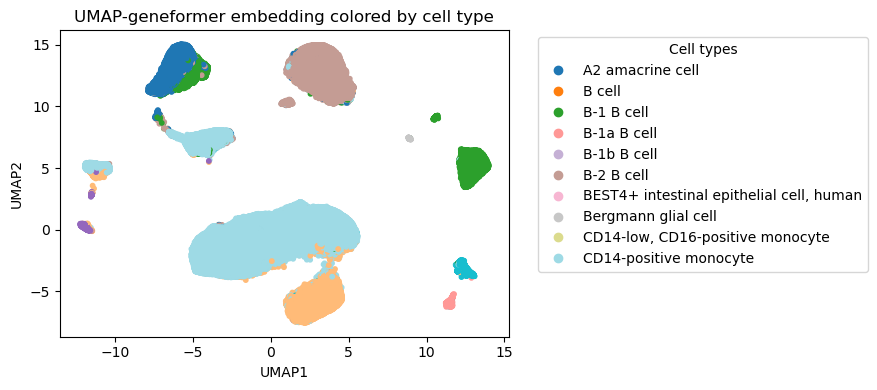

In [25]:
cell_types = adata.obs["cell_type"].astype("category")
codes = cell_types.cat.codes[df_geneformer.index]

plt.figure(figsize=(9,4))
scatter = plt.scatter(
    embedding_geneformer_umap[:,0],
    embedding_geneformer_umap[:,1],
    c=codes,
    cmap="tab20",
    s=10
)

handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, cell_types.cat.categories, title="Cell types", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("UMAP-geneformer embedding colored by cell type")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()


# Leiden Clustering

In [42]:
# convert to AnnData
adata = ad.AnnData(df_geneformer.values)
adata.obs_names = df_geneformer.index
adata.var_names = df_geneformer.columns

# build graph
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')

# Leiden clustering
sc.tl.leiden(adata, resolution=0.6)

# save clusters
adata.obs[['leiden']].to_csv("geneformer_leiden_clusters.csv")


/home/znazari/cellxgene_census2025_new/lib/python3.12/site-packages/anndata/_core/anndata.py:812: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/var/tmp/pbs.402329.pbs01/ipykernel_86352/1962948993.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.6)


In [ ]:
# convert to AnnData
adata = ad.AnnData(df_scvi.values)
adata.obs_names = df_scvi.index
adata.var_names = df_scvi.columns

# build graph
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')

# Leiden clustering
sc.tl.leiden(adata, resolution=0.6)

# save clusters
adata.obs[['leiden']].to_csv("scvi_leiden_clusters.csv")

In [ ]:
# UMAP
sc.tl.umap(adata)

# Plot Leiden clusters
sc.pl.umap(adata, color='leiden', legend_loc='on data')


In [17]:
read_leiden_clusters = pd.read_csv('/home/znazari/scRNAseq_parkinson/scvi_leiden_clusters.csv')

In [6]:
read_leiden_clusters_geneformer = pd.read_csv('/home/znazari/scRNAseq_parkinson/geneformer_leiden_clusters.csv')

In [25]:
df_merged = pd.concat([lm_data,read_leiden_clusters],axis=1)

In [10]:
df_merged_geneformer = pd.concat([lm_data,read_leiden_clusters_geneformer],axis=1)

In [7]:
read_leiden_clusters_geneformer

,Unnamed: 0,leiden
0,0,8
1,1,0
2,2,1
3,3,3
4,4,4
...,...,...
2096150,2096150,0
2096151,2096151,2
2096152,2096152,6
2096153,2096153,7


In [11]:
df_merged_geneformer

,observation_joinid,disease,cell_type,Unnamed: 0,leiden
0,MpT)aB)#*U,Parkinson disease,oligodendrocyte,0,8
1,qFT~wG^BCg,Parkinson disease,oligodendrocyte,1,0
2,fE`VpY%8fb,Parkinson disease,oligodendrocyte,2,1
3,g1Lr8^y)O(,Parkinson disease,oligodendrocyte,3,3
4,MR9tUCifao,Parkinson disease,astrocyte,4,4
...,...,...,...,...,...
2096150,25FK4DT!Rl,normal,oligodendrocyte,2096150,0
2096151,PdMVWS9R^v,Parkinson disease,glutamatergic neuron,2096151,2
2096152,Q&?JBHEFAz,Parkinson disease,central nervous system macrophage,2096152,6
2096153,@vUY6<XF#a,normal,oligodendrocyte precursor cell,2096153,7


In [29]:
df_merged.drop('Unnamed: 0',axis=1,inplace=True)

In [12]:
df_merged_geneformer.drop('Unnamed: 0',axis=1,inplace=True)

In [13]:
df_merged_geneformer.columns

Index(['observation_joinid', 'disease', 'cell_type', 'leiden'], dtype='object')

In [34]:
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score

# df = your dataframe
# columns: observation_joinid, disease, cell_type, leiden

# Compute NMI between Leiden clusters and cell types
nmi_celltype = normalized_mutual_info_score(df_merged['leiden'], df_merged['cell_type'])
print("NMI Leiden vs Cell Type:", nmi_celltype)

# Compute NMI between Leiden clusters and disease status
nmi_disease = normalized_mutual_info_score(df_merged['leiden'], df_merged['disease'])
print("NMI Leiden vs Disease:", nmi_disease)


NMI Leiden vs Cell Type: 0.6917196282142731
NMI Leiden vs Disease: 0.00379305461397704


In [14]:
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score

# df = your dataframe
# columns: observation_joinid, disease, cell_type, leiden

# Compute NMI between Leiden clusters and cell types
nmi_celltype = normalized_mutual_info_score(df_merged_geneformer['leiden'], df_merged_geneformer['cell_type'])
print("NMI Leiden vs Cell Type for geneformer:", nmi_celltype)

# Compute NMI between Leiden clusters and disease status
nmi_disease = normalized_mutual_info_score(df_merged_geneformer['leiden'], df_merged_geneformer['disease'])
print("NMI Leiden vs Disease for geneformer:", nmi_disease)


NMI Leiden vs Cell Type for geneformer: 0.7815659955480042
NMI Leiden vs Disease for geneformer: 0.0009802476269927226


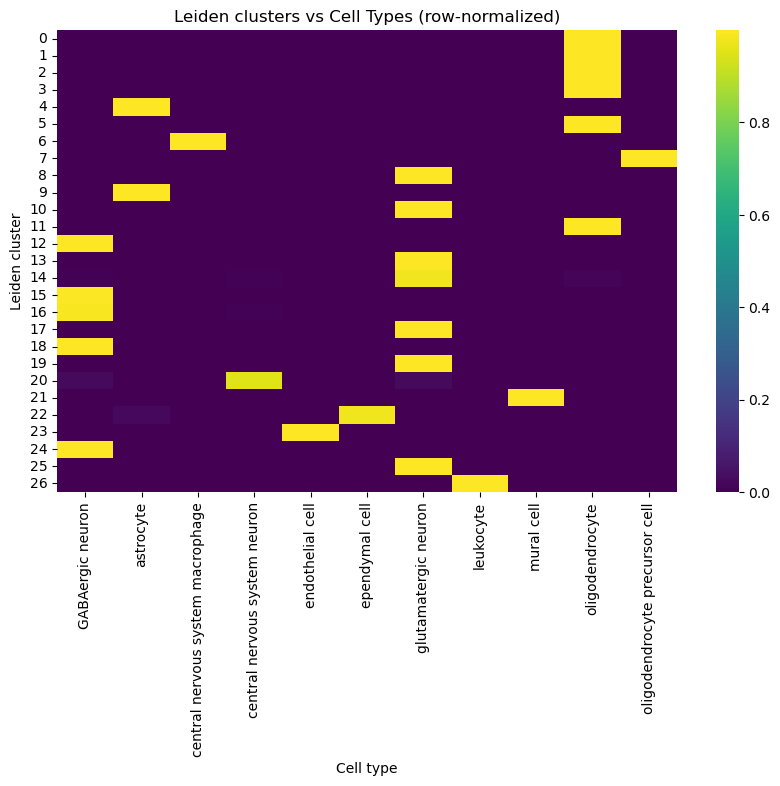

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

ct = pd.crosstab(df_merged['leiden'], df_merged['cell_type'], normalize='index')

plt.figure(figsize=(10,6))
sns.heatmap(ct, cmap='viridis', annot=False)
plt.title("Leiden clusters vs Cell Types (row-normalized)")
plt.ylabel("Leiden cluster")
plt.xlabel("Cell type")
plt.show()


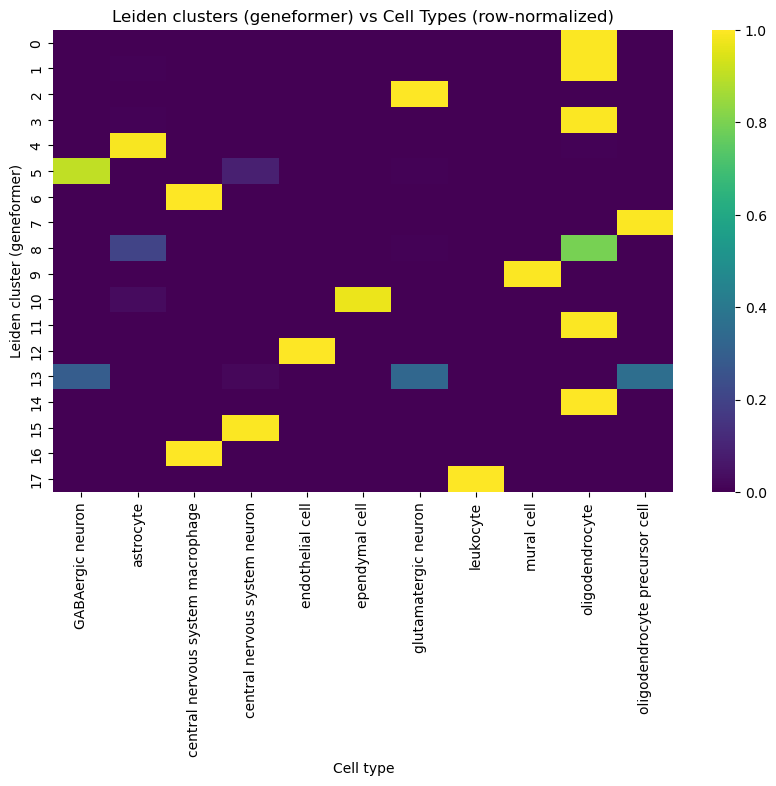

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

ct = pd.crosstab(df_merged_geneformer['leiden'], df_merged_geneformer['cell_type'], normalize='index')

plt.figure(figsize=(10,6))
sns.heatmap(ct, cmap='viridis', annot=False)
plt.title("Leiden clusters (geneformer) vs Cell Types (row-normalized)")
plt.ylabel("Leiden cluster (geneformer)")
plt.xlabel("Cell type")
plt.show()

In [35]:
# whether disease is enriched in specific clusters:
pd.crosstab(df_merged['leiden'], df_merged['disease'], normalize='index')


disease,Parkinson disease,normal
leiden,,
0,0.820341,0.179659
1,0.785494,0.214506
2,0.757610,0.242390
3,0.743738,0.256262
4,0.807025,0.192975
5,0.745319,0.254681
6,0.814358,0.185642
7,0.787008,0.212992
8,0.741383,0.258617
